# Filter the glacier length and area time series

In this short tutorial, we show how to deal with unwanted "spikes" in the length and area time series of individual glaciers. These happen because OGGM currently doesn't differentiate between snow and ice, i.e. occasional years with large snowfall can artificially increase the glacier area.

While the best solution would be to deal with this in OGGM, this is currently not possible because we do not have a generally applicable solution to this problem. In the meantime, we recommend a simple workaround.

## Set-up 

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import os

In [2]:
from oggm import cfg, utils, workflow, tasks
cfg.initialize()

2021-02-02 22:45:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-02 22:45:01: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-02 22:45:01: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-02 22:45:01: oggm.utils: Checking the download verification file checksum...


In [3]:
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Filter')

### Define the glaciers for the run 

We take the Kesslewandferner in the Austrian Alps:

In [4]:
rgi_ids = ['RGI60-11.00787']

### Glacier directories 

In [5]:
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=4, prepro_border=80)

2021-02-02 22:45:06: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2021-02-02 22:45:06: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-02 22:45:06: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/centerlines/qc3/pcp2.5/no_match/RGI62/b_080/L4/RGI60-11/RGI60-11.00.tar
2021-02-02 22:45:10: oggm.core.flowline: (RGI60-11.00787) run_random_climate_commitment
2021-02-02 22:45:10: oggm.core.flowline: (RGI60-11.00787) flowline_model_run_commitment


## Run

We can step directly to a new experiment! This runs under a andom climate representative for the recent climate (1985-2015) and a warm temperature bias:

In [6]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs,
                             nyears=200, y0=2000, seed=5,
                             output_filesuffix='_commitment');

2021-02-02 22:45:10: oggm.workflow: Execute entity task run_random_climate on 1 glaciers


## The problem 

In [7]:
ds = utils.compile_run_output(gdirs, filesuffix='_commitment')
ds = ds.isel(rgi_id=0)  # take just the one glacier

2021-02-02 22:45:13: oggm.utils: Applying compile_run_output on 1 gdirs.


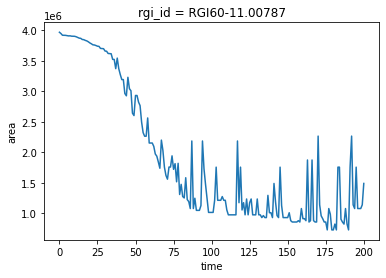

In [8]:
ds.area.plot();

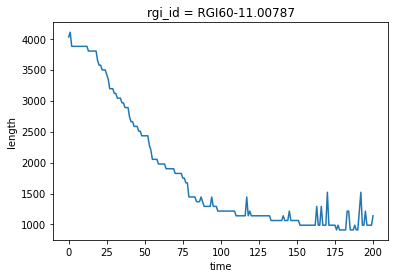

In [9]:
ds.length.plot();

For small areas, the glacier has the unrealistic "spikes" described above.

## Workaround 

A good way to deal with the issue is to run a moving filter which keeps the smallest area or length in a given window size:

In [10]:
roll_yrs = 5

In [11]:
# Take the minimum out of 5 years
ts = ds.area.to_series()
ts = ts.rolling(roll_yrs).min()
ts.iloc[0:roll_yrs] = ts.iloc[roll_yrs]

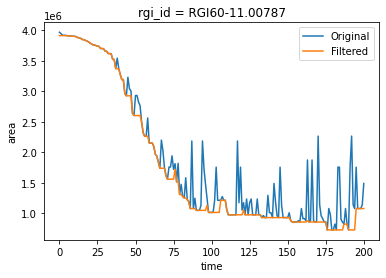

In [12]:
# Plot
ds.area.plot(label='Original');
ts.plot(label='Filtered');
plt.legend();

It works the same with length:

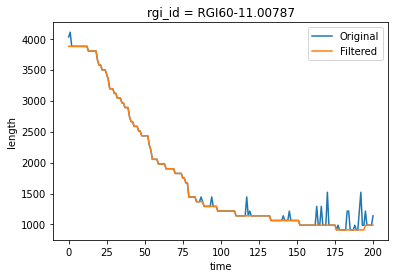

In [13]:
# Take the minimum out of 5 years
ts = ds.length.to_series()
ts = ts.rolling(roll_yrs).min()
ts.iloc[0:roll_yrs] = ts.iloc[roll_yrs]
# Plot
ds.length.plot(label='Original');
ts.plot(label='Filtered');
plt.legend();

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)